In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression, HuberRegressor
import pickle
import itertools
import time
import ot
import os
from scipy.stats import rankdata, kendalltau, spearmanr
import seaborn as sns
from datetime import datetime
# from scipy.signal import savgol_filter
# from scipy.ndimage import gaussian_filter1d

## Transition matrix

In [2]:
worker_trans = np.array([[0.4, 0.15, 0.15, 0.15, 0.15], [0.15, 0.4, 0.15, 0.15, 0.15],
                         [0.15, 0.15, 0.4, 0.15, 0.15], [0.15, 0.15, 0.15, 0.4, 0.15],
                         [0.15, 0.15, 0.15, 0.15, 0.4]])

firm_trans = np.array([[10., 0., 0., 0., 0.], [0., 14., 6., 0., 0.],
                       [0., 6., 14., 0., 0.], [0., 0., 0., 18., 2.],
                       [0., 0., 0., 1., 9.]])

In [3]:
# initial distribution
firm_trans.sum(axis=1)/firm_trans.sum()

array([0.125, 0.25 , 0.25 , 0.25 , 0.125])

In [4]:
worker_trans.sum(axis=1)/worker_trans.sum()

array([0.2, 0.2, 0.2, 0.2, 0.2])

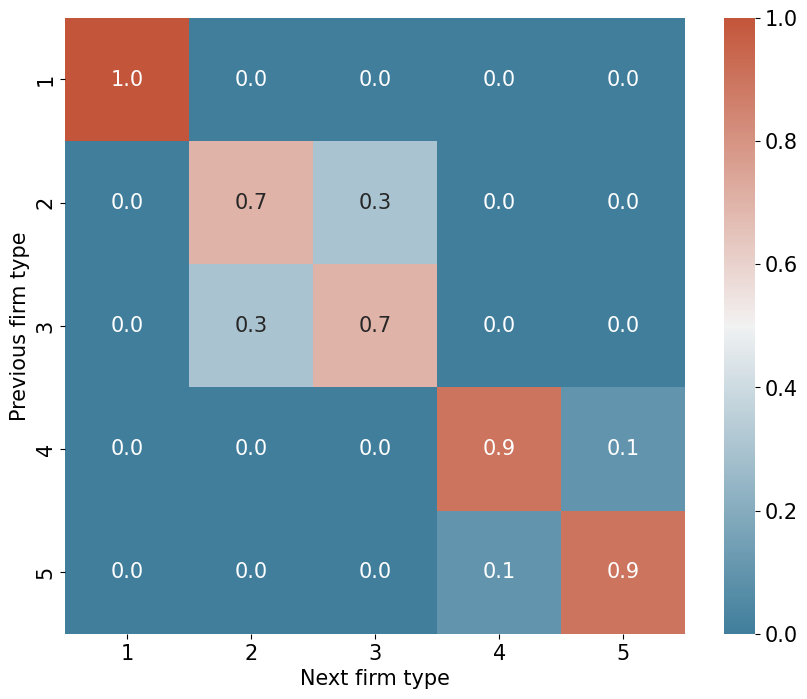

In [5]:
# firm trans has been normalized here
x_shape = firm_trans.shape[0]

for row in range(5):
    firm_trans[row, :] = firm_trans[row, :]/firm_trans[row, :].sum()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(firm_trans, xticklabels=np.arange(1, x_shape+1),
                 yticklabels=np.arange(1, x_shape+1),
                 annot=True, fmt=".1f", annot_kws={"fontsize": 15}, cmap=cmap)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Next firm type', fontsize=15)
plt.ylabel('Previous firm type', fontsize=15)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
plt.savefig('Cobbfirm_trans.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [6]:
# Calculate marginals at time 1, 2, 3, ...
first_ = np.array([0.125, 0.25 , 0.25 , 0.25 , 0.125])
np.matmul(np.matmul(first_, firm_trans), firm_trans)

array([0.125 , 0.25  , 0.25  , 0.2275, 0.1475])

In [7]:
np.matmul(np.matmul(np.matmul(np.matmul(first_, firm_trans), firm_trans), firm_trans), firm_trans)

array([0.125 , 0.25  , 0.25  , 0.2131, 0.1619])

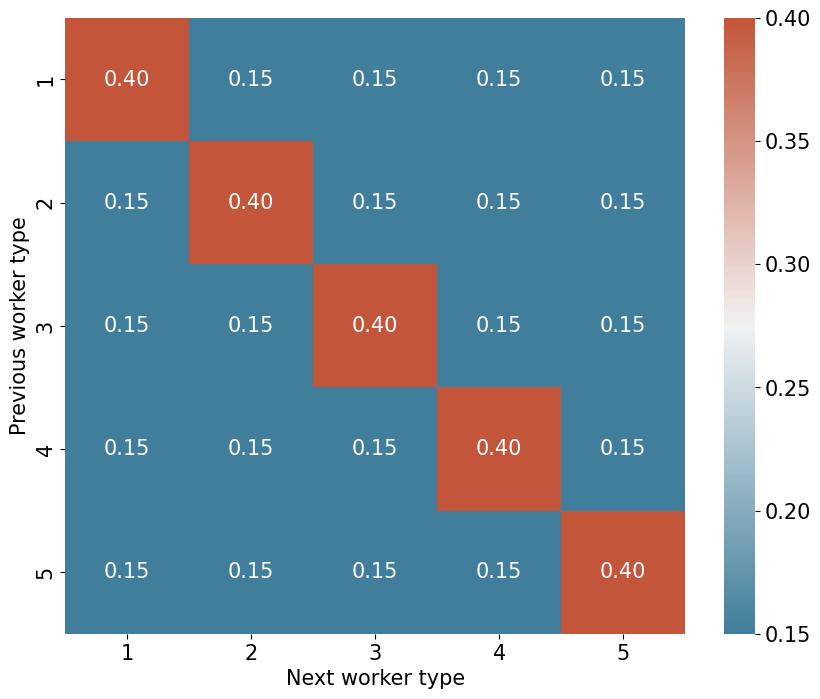

In [8]:
x_shape = worker_trans.shape[0]

for row in range(5):
    worker_trans[row, :] = worker_trans[row, :]/worker_trans[row, :].sum()

cmap = sns.diverging_palette(230, 20, as_cmap=True)
plt.figure(figsize=(10, 8))
ax = sns.heatmap(worker_trans, xticklabels=np.arange(1, x_shape+1),
                 yticklabels=np.arange(1, x_shape+1),
                 annot=True, fmt=".2f", annot_kws={"fontsize": 15}, cmap=cmap)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel('Next worker type', fontsize=15)
plt.ylabel('Previous worker type', fontsize=15)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=15)
plt.savefig('Cobbworker_trans.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [9]:
# Calculate marginals at time 1, 2, 3, ...
worker_first = np.array([0.2, 0.2, 0.2, 0.2, 0.2])
np.matmul(worker_first, worker_trans)

array([0.2, 0.2, 0.2, 0.2, 0.2])

## Kendall rank correlation between firm/worker paired

In [10]:
alpha_arr = np.linspace(-0.5, 0.5, 51)*10.0

In [11]:
with open('./corr_logs/corr_hist.pickle', 'rb') as fp:
        corr_hist = pickle.load(fp)

In [12]:
np.where(corr_hist == corr_hist[0])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33],
       dtype=int64),)

In [13]:
alpha_arr[33]

1.6000000000000003

In [14]:
plt.style.use('seaborn-v0_8-whitegrid')

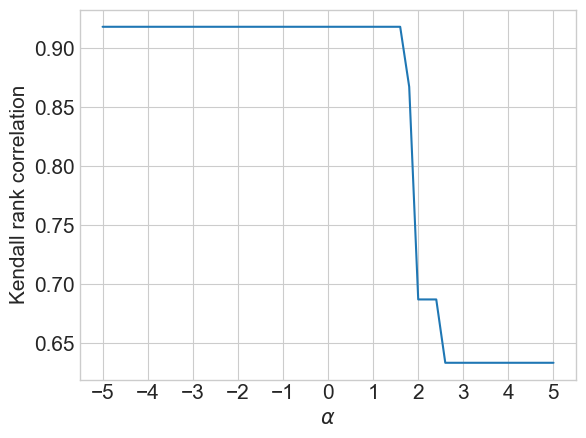

In [16]:
plt.plot(alpha_arr, corr_hist)
plt.xticks(np.arange(11) - 5)
plt.tick_params(axis='both', which='major', labelsize=15)
plt.xlabel(r'$\alpha$', fontsize=15)
plt.ylabel('Kendall rank correlation', fontsize=15)   
plt.savefig('Cobb_corr.pdf', format='pdf', dpi=1000, bbox_inches='tight', pad_inches=0.1)

In [17]:
# check the optiaml transport plan
with open('./corr_logs/alpha_27/ot_init.pickle', 'rb') as fp:
        ot_init = pickle.load(fp)

In [18]:
ot_init

array([[0.125, 0.   , 0.   , 0.   , 0.   ],
       [0.075, 0.175, 0.   , 0.   , 0.   ],
       [0.   , 0.025, 0.2  , 0.025, 0.   ],
       [0.   , 0.   , 0.   , 0.175, 0.075],
       [0.   , 0.   , 0.   , 0.   , 0.125]])

In [19]:
# check the optimal wage
with open('./corr_logs/alpha_35/wage_init.pickle', 'rb') as fp:
        wage_init = pickle.load(fp)

In [20]:
wage_init

array([0.66321927, 0.36394362, 0.21091627, 0.12733212, 0.        ])

In [21]:
mu = np.ones(100)/100
mu[0] = 0.005
mu[1] = 0.015
nu = np.ones(100)/100
mu[-1] = 0.005
mu[-2] = 0.015
cost = np.zeros((100, 100))
xip = 0.1
xiu = 0.1

for x in range(100):
    for z in range(100):
        if z >= x:
            cost[x, z] = -x/100 - z/100 + 1/xip*(z/100 - x/100)**xip
        else:
            cost[x, z] = -x/100 - z/100 + 1/xiu*(x/100 - z/100)**xiu

In [22]:
res = ot.emd(mu, nu, cost, log=True)
wage = res[1]['u']

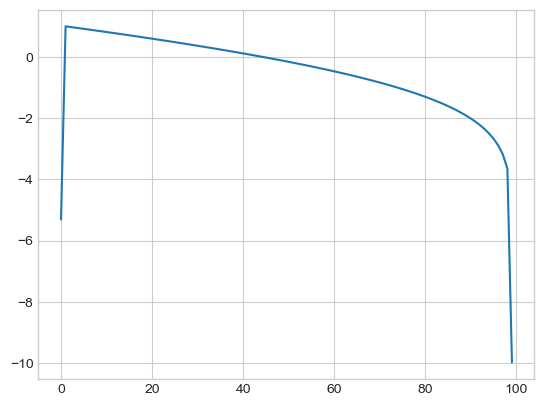

In [23]:
plt.plot(wage)